# Data Processing

In [1]:
import random
import pandas as pd
import numpy as np
import igraph as ig
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are 
# labelled class1 (illicit).
#Twenty-one percent (42,019) are labelled class2 (licit). 
#The remaining transactions are not labelled with regard to licit versus illicit.
classes_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_classes.csv"
edges_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_edgelist.csv"
features_path = "../elliptic_bitcoin_dataset/modified_elliptic_txs_features.csv"

classes = pd.read_csv(classes_path)
edges = pd.read_csv(edges_path)
feat_cols = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
feats = pd.read_csv(features_path, header=None, names=feat_cols)
classes.columns = ['txId', 'label']
df = classes.set_index('txId').join(feats.set_index('txId'))

In [3]:
label_colors = {'1':'red', '2':'green', 'unknown':'gray'}

tx_graph = ig.Graph(directed=True)

edges_dict = {tx_id: i for i, tx_id in enumerate(classes['txId'])}

tx_graph.add_vertices(len(classes))
tx_graph.vs['id'] = list(classes['txId'])
tx_graph.vs['type'] = list(classes['label'])
tx_graph.vs['time_step'] = list(feats['time_step'])
tx_graph.vs['color'] = [label_colors[label] for label in classes['label']]

edges_list = [(edges_dict[edges['txId1'][i]], edges_dict[edges['txId2'][i]]) for i in tqdm(range(len(edges)))]
tx_graph.add_edges(edges_list)

100%|██████████| 234355/234355 [00:00<00:00, 238621.25it/s]


In [4]:
betweenness = tx_graph.betweenness(directed=True)
#df.insert(1, 'betweenness', betweenness, True)

centralities = tx_graph.closeness()
df.insert(1, 'closeness', centralities, True)

in_degree = tx_graph.degree(mode="in")
df.insert(1, 'in-degree', in_degree)

out_degree = tx_graph.degree(mode='out')
df.insert(1, 'out-degree', out_degree)

clustering_coeff = tx_graph.transitivity_local_undirected(mode='zero')
df.insert(1, 'clustering_coeff', clustering_coeff)

pagerank_scores = tx_graph.pagerank(directed=True)
df.insert(1, 'pagerank', pagerank_scores, True)

In [5]:
with open('../data/Shortest paths with one random sample for every node.txt', 'r') as file:
    lines = file.readlines()

shortest_paths = [float(line.strip()) for line in lines]
df.insert(1, 'avg_shortest_paths', shortest_paths, True)

In [6]:
df.head()

,label,avg_shortest_paths,pagerank,clustering_coeff,out-degree,in-degree,closeness,time_step,trans_feat_0,trans_feat_1,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
txId,,,,,,,,,,,,,,,,,,,,,
0,unknown,10.560976,0.000004,0.000000,1,1,0.092392,1,-0.171469,-0.184668,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
5577,unknown,11.486842,0.000005,0.000000,1,1,0.084580,1,-0.171484,-0.184668,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,unknown,7.410526,0.000005,0.000000,2,1,0.134507,1,-0.172107,-0.184668,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
537,2,6.857143,0.000297,0.000621,1,160,0.155365,1,0.163054,1.963790,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
2,unknown,9.661290,0.000002,0.266667,8,2,0.100978,1,1.011523,-0.081127,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [7]:
df.shape

(203769, 173)

# Classification

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn import metrics  
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer, roc_curve, roc_auc_score

In [9]:
#Transform the dataframe in a suitable input for KMeans. We drop the columns containing
#the correct labels
df.drop(df[df["label"] == "unknown"].index, inplace=True)

y = df['label']
X = df.drop(columns=['label'])
#X = X.loc[:, 'time_step':'trans_feat_92']
X.head()

,avg_shortest_paths,pagerank,clustering_coeff,out-degree,in-degree,closeness,time_step,trans_feat_0,trans_feat_1,trans_feat_2,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
txId,,,,,,,,,,,,,,,,,,,,,
537,6.857143,0.000297,0.000621,1,160,0.155365,1,0.163054,1.963790,-0.646376,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4133,6.771084,0.000076,0.001130,1,59,0.134193,1,-0.005027,0.578941,-0.091383,...,-0.577099,-0.613614,0.241128,0.241406,0.604120,0.008632,-0.131155,0.333211,-0.120613,-0.119792
5,10.216216,0.000002,0.000000,2,0,0.099405,1,-0.147852,-0.184668,-1.201369,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
5187,8.028169,0.000002,0.000000,1,1,0.110372,1,-0.151357,-0.184668,-1.201369,...,-0.539735,-0.582077,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
8,6.848485,0.000002,0.000000,1,1,0.139805,1,-0.172306,-0.184668,-1.201369,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.068266,-0.084674,-0.054450,-1.760926,-1.760984


In [10]:
X_train = X[X['time_step'].between(1, 34)]
y_train = y[X['time_step'].between(1, 34)]

X_test = X[X['time_step'].between(35, 49)]
y_test = y[X['time_step'].between(35, 49)]

#X_train, y_train = shuffle(X_train, y_train, random_state=42)
#X_test, y_test = shuffle(X_test, y_test, random_state=42)

#X_train = X_train.reset_index(drop=True)
#y_train = y_train.reset_index(drop=True)
#X_test = X_test.reset_index(drop=True)
#y_test = y_test.reset_index(drop=True)

In [11]:
#list(X_train.columns)

In [12]:
print(X_train.shape)
print(X_test.shape)

(29894, 172)
(16670, 172)


### Local Features

In [13]:
X_train_LF = X_train.loc[:, 'time_step':'trans_feat_92']
X_test_LF = X_test.loc[:, 'time_step':'trans_feat_92']

In [14]:
clf_LF = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_LF.fit(X_train_LF, y_train)
y_pred_LF = clf_LF.predict(X_test_LF)

In [15]:
precision_ilicit_lf = precision_score(y_test, y_pred_LF, pos_label='1')
recall_ilicit_lf = recall_score(y_test, y_pred_LF, pos_label='1')
f1_ilicit_lf = f1_score(y_test, y_pred_LF, pos_label='1')
f1_scorer_lf = make_scorer(f1_score, pos_label='1')
scores_lf = cross_val_score(clf_LF, X_train_LF, y_train, cv=5, scoring=f1_scorer_lf)

print(f'Precision local features: {precision_ilicit_lf}')
print(f'Recall local features: {recall_ilicit_lf}')
print(f'F1 local features: {f1_ilicit_lf}')
print("Cross-validated F1 Score local features:", scores_lf.mean())

Precision local features: 0.8974654377880185
Recall local features: 0.7192982456140351
F1 local features: 0.7985648385443362
Cross-validated F1 Score local features: 0.8149904219167224


### All Features

In [16]:
X_train_AF = X_train.loc[:, 'time_step':]
X_test_AF = X_test.loc[:, 'time_step':]

In [17]:
clf_AF = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_AF.fit(X_train_AF, y_train)
y_pred_AF = clf_AF.predict(X_test_AF)

In [18]:
precision_ilicit_af = precision_score(y_test, y_pred_AF, pos_label='1')
recall_ilicit_af = recall_score(y_test, y_pred_AF, pos_label='1')
f1_ilicit_af = f1_score(y_test, y_pred_AF, pos_label='1')
f1_scorer_af = make_scorer(f1_score, pos_label='1')
scores_af = cross_val_score(clf_AF, X_train_AF, y_train, cv=5, scoring=f1_scorer_af)

print(f'Precision all features: {precision_ilicit_af}')
print(f'Recall all features: {recall_ilicit_af}')
print(f'F1 all features: {f1_ilicit_af}')
print("Cross-validated F1 Score all features:", scores_af.mean())

Precision all features: 0.9618696186961869
Recall all features: 0.7220683287165282
F1 all features: 0.8248945147679325
Cross-validated F1 Score all features: 0.7666699777132638


### Local Features + Node Features

In [19]:
X_train_LF_NF = X_train.loc[:, :'trans_feat_92']
X_test_LF_NF = X_test.loc[:, :'trans_feat_92']

In [20]:
clf_LF_NF = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_LF_NF.fit(X_train_LF_NF, y_train)
y_pred_LF_NF = clf_LF_NF.predict(X_test_LF_NF)

In [21]:
precision_ilicit_lf_nf = precision_score(y_test, y_pred_LF_NF, pos_label='1')
recall_ilicit_lf_nf = recall_score(y_test, y_pred_LF_NF, pos_label='1')
f1_ilicit_lf_nf = f1_score(y_test, y_pred_LF_NF, pos_label='1')
f1_scorer_lf_nf = make_scorer(f1_score, pos_label='1')
scores_lf_nf = cross_val_score(clf_LF_NF, X_train_LF_NF, y_train, cv=5, scoring=f1_scorer_lf_nf)

print(f'Precision local features + node features: {precision_ilicit_lf_nf}')
print(f'Recall local features + node features: {recall_ilicit_lf_nf}')
print(f'F1 local features + node features: {f1_ilicit_lf_nf}')
print("Cross-validated F1 Score local features + node featuress:", scores_lf_nf.mean())

Precision local features + node features: 0.8922018348623854
Recall local features + node features: 0.7183748845798708
F1 local features + node features: 0.7959079283887468
Cross-validated F1 Score local features + node featuress: 0.8184754147183328


### All Features + Node Features

In [22]:
X_train_AF_NF = X_train.loc[:, :]
X_test_AF_NF = X_test.loc[:, :]

In [23]:
clf_AF_NF = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_AF_NF.fit(X_train_AF_NF, y_train)
y_pred_AF_NF = clf_AF_NF.predict(X_test_AF_NF)

In [24]:
precision_ilicit_af_nf = precision_score(y_test, y_pred_AF_NF, pos_label='1')
recall_ilicit_af_nf = recall_score(y_test, y_pred_AF_NF, pos_label='1')
f1_ilicit_af_nf = f1_score(y_test, y_pred_AF_NF, pos_label='1')
f1_scorer_af_nf = make_scorer(f1_score, pos_label='1')
scores_af_nf = cross_val_score(clf_AF_NF, X_train_AF_NF, y_train, cv=5, scoring=f1_scorer_af_nf)

print(f'Precision all features + node features: {precision_ilicit_af_nf}')
print(f'Recall all features + node features: {recall_ilicit_af_nf}')
print(f'F1 all features + node features: {f1_ilicit_af_nf}')
print("Cross-validated F1 Score all features + node featuress:", scores_af_nf.mean())

Precision all features + node features: 0.9558823529411765
Recall all features + node features: 0.7202216066481995
F1 all features + node features: 0.8214849921011058
Cross-validated F1 Score all features + node featuress: 0.7615967805755481


### Node Embeddings (GCN)

In [25]:
embeddings = pd.read_csv('../data/embeddings_gcn.csv')
embeddings.drop(embeddings[embeddings["label"] == "unknown"].index, inplace=True)
embeddings

y_gcn = embeddings['label']
X_gcn = embeddings.drop(columns=['label'])

X_train_gcn = X_gcn[X_gcn['time_step'].between(1, 34)]
y_train_gcn = y_gcn[X_gcn['time_step'].between(1, 34)]

X_test_gcn = X_gcn[X_gcn['time_step'].between(35, 49)]
y_test_gcn = y_gcn[X_gcn['time_step'].between(35, 49)]

X_train_gcn = X_train_gcn.loc[:, '0':'127']
X_test_gcn = X_test_gcn.loc[:, '0':'127']

clf_gcn = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_gcn.fit(X_train_gcn, y_train_gcn)
y_pred_gcn = clf_gcn.predict(X_test_gcn)

precision_ilicit_gcn = precision_score(y_test_gcn, y_pred_gcn, pos_label='1')
recall_ilicit_gcn = recall_score(y_test_gcn, y_pred_gcn, pos_label='1')
f1_ilicit_gcn = f1_score(y_test_gcn, y_pred_gcn, pos_label='1')
f1_scorer_gcn = make_scorer(f1_score, pos_label='1')
scores_gcn = cross_val_score(clf_gcn, X_train_gcn, y_train_gcn, cv=5, scoring=f1_scorer_gcn)

print(f'Precision node embeddings (GCN): {precision_ilicit_gcn}')
print(f'Recall node embeddings (GCN): {recall_ilicit_gcn}')
print(f'F1 node embeddings (GCN): {f1_ilicit_gcn}')
print("Cross-validated F1 Score node embeddings (GCN):", scores_gcn.mean())

Precision node embeddings (GCN): 0.6432160804020101
Recall node embeddings (GCN): 0.11819021237303785
F1 node embeddings (GCN): 0.1996879875195008
Cross-validated F1 Score node embeddings (GCN): 0.4613445138860911


### Embeddings + All Features (GCN)

In [26]:
df_ne_af = df.loc[:, 'time_step':].join(embeddings.drop(columns=['time_step']).set_index('txId'))
X_ne_af = df_ne_af.drop(columns=['label'])
y_ne_af = df_ne_af['label']

X_train_ne_af = X_ne_af[X_ne_af['time_step'].between(1, 34)]
y_train_ne_af = y_ne_af[X_ne_af['time_step'].between(1, 34)]

X_test_ne_af = X_ne_af[X_ne_af['time_step'].between(35, 49)]
y_test_ne_af = y_ne_af[X_ne_af['time_step'].between(35, 49)]

clf_ne_af = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_ne_af.fit(X_train_ne_af, y_train_ne_af)
y_pred_ne_af = clf_ne_af.predict(X_test_ne_af)

precision_ilicit_ne_af = precision_score(y_test_ne_af, y_pred_ne_af, pos_label='1')
recall_ilicit_ne_af = recall_score(y_test_ne_af, y_pred_ne_af, pos_label='1')
f1_ilicit_ne_af = f1_score(y_test_ne_af, y_pred_ne_af, pos_label='1')
f1_scorer_ne_af = make_scorer(f1_score, pos_label='1')
scores_ne_af = cross_val_score(clf_ne_af, X_train_ne_af, y_train_ne_af, cv=5, scoring=f1_scorer_ne_af)

print(f'Precision embeddings + all features: {precision_ilicit_ne_af}')
print(f'Recall embeddings + all features: {recall_ilicit_ne_af}')
print(f'F1 embeddings + all features: {f1_ilicit_ne_af}')
print("Cross-validated F1 Score embeddings + all features:", scores_ne_af.mean())


Precision embeddings + all features: 0.96625
Recall embeddings + all features: 0.7137580794090489
F1 embeddings + all features: 0.8210302708443973
Cross-validated F1 Score embeddings + all features: 0.672924619290299


### Embeddings + All Features + Node Features (GCN)

In [27]:
#df_ne_af_nf = df.loc[:,:].join(embeddings.drop(columns=['time_step']).set_index('txId'))
df_ne_af_nf = df.loc[:,:].join(embeddings.drop(columns=['time_step', 'label']).set_index('txId'))
X_ne_af_nf = df_ne_af_nf.drop(columns=['label'])
y_ne_af_nf = df_ne_af_nf['label']

X_train_ne_af_nf = X_ne_af_nf[X_ne_af_nf['time_step'].between(1, 34)]
y_train_ne_af_nf = y_ne_af_nf[X_ne_af_nf['time_step'].between(1, 34)]

X_test_ne_af_nf = X_ne_af_nf[X_ne_af_nf['time_step'].between(35, 49)]
y_test_ne_af_nf = y_ne_af_nf[X_ne_af_nf['time_step'].between(35, 49)]

clf_ne_af_nf = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_ne_af_nf.fit(X_train_ne_af_nf, y_train_ne_af_nf)
y_pred_ne_af_nf = clf_ne_af_nf.predict(X_test_ne_af_nf)

precision_ilicit_ne_af_nf = precision_score(y_test_ne_af_nf, y_pred_ne_af_nf, pos_label='1')
recall_ilicit_ne_af_nf = recall_score(y_test_ne_af_nf, y_pred_ne_af_nf, pos_label='1')
f1_ilicit_ne_af_nf = f1_score(y_test_ne_af_nf, y_pred_ne_af_nf, pos_label='1')
f1_scorer_ne_af_nf = make_scorer(f1_score, pos_label='1')
scores_ne_af_nf = cross_val_score(clf_ne_af_nf, X_train_ne_af_nf, y_train_ne_af_nf, cv=5, scoring=f1_scorer_ne_af_nf)

print(f'Precision embeddings + all features + node features: {precision_ilicit_ne_af_nf}')
print(f'Recall embeddings + all features + node features: {recall_ilicit_ne_af_nf}')
print(f'F1 embeddings + all features + node features: {f1_ilicit_ne_af_nf}')
print("Cross-validated F1 Score embeddings + all features:", scores_ne_af_nf.mean())

Precision embeddings + all features + node features: 0.9720812182741116
Recall embeddings + all features + node features: 0.7072945521698984
F1 embeddings + all features + node features: 0.8188134687332977
Cross-validated F1 Score embeddings + all features: 0.6590728593908002


## Node Emebddings (GAT)

In [28]:
embeddings_gat = pd.read_csv('../data/embeddings_gat.csv')

embeddings_gat.drop(embeddings_gat[embeddings_gat["label"] == "unknown"].index, inplace=True)
embeddings_gat

y_gat = embeddings_gat['label']
X_gat = embeddings_gat.drop(columns=['label'])

X_train_gat = X_gat[X_gat['time_step'].between(1, 34)]
y_train_gat = y_gat[X_gat['time_step'].between(1, 34)]

X_test_gat = X_gat[X_gat['time_step'].between(35, 49)]
y_test_gat = y_gat[X_gat['time_step'].between(35, 49)]

X_train_gat = X_train_gat.loc[:, '0':'127']
X_test_gat = X_test_gat.loc[:, '0':'127']

clf_gat = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_gat.fit(X_train_gat, y_train_gat)
y_pred_gat = clf_gat.predict(X_test_gat)

precision_ilicit_gat = precision_score(y_test_gat, y_pred_gat, pos_label='1')
recall_ilicit_gat = recall_score(y_test_gat, y_pred_gat, pos_label='1')
f1_ilicit_gat = f1_score(y_test_gat, y_pred_gat, pos_label='1')
f1_scorer_gat = make_scorer(f1_score, pos_label='1')
scores_gat = cross_val_score(clf_gat, X_train_gat, y_train_gat, cv=5, scoring=f1_scorer_gat)

print(f'Precision node embeddings (GAT): {precision_ilicit_gat}')
print(f'Recall node embeddings (GAT): {recall_ilicit_gat}')
print(f'F1 node embeddings (GAT): {f1_ilicit_gat}')
print("Cross-validated F1 Score node embeddings (GAT):", scores_gat.mean())

Precision node embeddings (GAT): 0.54
Recall node embeddings (GAT): 0.024930747922437674
F1 node embeddings (GAT): 0.04766107678729038
Cross-validated F1 Score node embeddings (GAT): 0.25100068318898444


## Node Embeddings + All Features (GAT)

In [29]:
df_ne_af = df.loc[:, 'time_step':].join(embeddings_gat.drop(columns=['time_step']).set_index('txId'))
X_ne_af = df_ne_af.drop(columns=['label'])
y_ne_af = df_ne_af['label']

X_train_ne_af = X_ne_af[X_ne_af['time_step'].between(1, 34)]
y_train_ne_af = y_ne_af[X_ne_af['time_step'].between(1, 34)]

X_test_ne_af = X_ne_af[X_ne_af['time_step'].between(35, 49)]
y_test_ne_af = y_ne_af[X_ne_af['time_step'].between(35, 49)]

clf_ne_af = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_ne_af.fit(X_train_ne_af, y_train_ne_af)
y_pred_ne_af = clf_ne_af.predict(X_test_ne_af)

precision_ilicit_ne_af = precision_score(y_test_ne_af, y_pred_ne_af, pos_label='1')
recall_ilicit_ne_af = recall_score(y_test_ne_af, y_pred_ne_af, pos_label='1')
f1_ilicit_ne_af = f1_score(y_test_ne_af, y_pred_ne_af, pos_label='1')
f1_scorer_ne_af = make_scorer(f1_score, pos_label='1')
scores_ne_af = cross_val_score(clf_ne_af, X_train_ne_af, y_train_ne_af, cv=5, scoring=f1_scorer_ne_af)

print(f'Precision embeddings + all features: {precision_ilicit_ne_af}')
print(f'Recall embeddings + all features: {recall_ilicit_ne_af}')
print(f'F1 embeddings + all features: {f1_ilicit_ne_af}')
print("Cross-validated F1 Score embeddings + all features:", scores_ne_af.mean())

Precision embeddings + all features: 0.9496124031007752
Recall embeddings + all features: 0.6786703601108033
F1 embeddings + all features: 0.7915993537964459
Cross-validated F1 Score embeddings + all features: 0.7263013121398129


## Node Embeddings + All Features + Node Features (GAT)

In [30]:
df_ne_af_nf = df.loc[:,:].join(embeddings_gat.drop(columns=['time_step', 'label']).set_index('txId'))
X_ne_af_nf = df_ne_af_nf.drop(columns=['label'])
y_ne_af_nf = df_ne_af_nf['label']

X_train_ne_af_nf = X_ne_af_nf[X_ne_af_nf['time_step'].between(1, 34)]
y_train_ne_af_nf = y_ne_af_nf[X_ne_af_nf['time_step'].between(1, 34)]

X_test_ne_af_nf = X_ne_af_nf[X_ne_af_nf['time_step'].between(35, 49)]
y_test_ne_af_nf = y_ne_af_nf[X_ne_af_nf['time_step'].between(35, 49)]

clf_ne_af_nf = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_ne_af_nf.fit(X_train_ne_af_nf, y_train_ne_af_nf)
y_pred_ne_af_nf = clf_ne_af_nf.predict(X_test_ne_af_nf)

precision_ilicit_ne_af_nf = precision_score(y_test_ne_af_nf, y_pred_ne_af_nf, pos_label='1')
recall_ilicit_ne_af_nf = recall_score(y_test_ne_af_nf, y_pred_ne_af_nf, pos_label='1')
f1_ilicit_ne_af_nf = f1_score(y_test_ne_af_nf, y_pred_ne_af_nf, pos_label='1')
f1_scorer_ne_af_nf = make_scorer(f1_score, pos_label='1')
scores_ne_af_nf = cross_val_score(clf_ne_af_nf, X_train_ne_af_nf, y_train_ne_af_nf, cv=5, scoring=f1_scorer_ne_af_nf)

print(f'Precision embeddings + all features + node features: {precision_ilicit_ne_af_nf}')
print(f'Recall embeddings + all features + node features: {recall_ilicit_ne_af_nf}')
print(f'F1 embeddings + all features + node features: {f1_ilicit_ne_af_nf}')
print("Cross-validated F1 Score embeddings + all features:", scores_ne_af_nf.mean())

Precision embeddings + all features + node features: 0.9528795811518325
Recall embeddings + all features + node features: 0.6722068328716528
F1 embeddings + all features + node features: 0.7883053600433135
Cross-validated F1 Score embeddings + all features: 0.7559465398645576


## Node Emebddings (GIN)

In [31]:
embeddings_gin = pd.read_csv('../data/embeddings_gin.csv')

embeddings_gin.drop(embeddings_gin[embeddings_gin["label"] == "unknown"].index, inplace=True)
embeddings_gin

y_gin = embeddings_gin['label']
X_gin = embeddings_gin.drop(columns=['label'])

X_train_gin = X_gin[X_gin['time_step'].between(1, 34)]
y_train_gin = y_gin[X_gin['time_step'].between(1, 34)]

X_test_gin = X_gin[X_gin['time_step'].between(35, 49)]
y_test_gin = y_gin[X_gin['time_step'].between(35, 49)]

X_train_gin = X_train_gin.loc[:, '0':'127']
X_test_gin = X_test_gin.loc[:, '0':'127']

clf_gin = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_gin.fit(X_train_gin, y_train_gin)
y_pred_gin = clf_gin.predict(X_test_gin)

precision_ilicit_gin = precision_score(y_test_gin, y_pred_gin, pos_label='1')
recall_ilicit_gin = recall_score(y_test_gin, y_pred_gin, pos_label='1')
f1_ilicit_gin = f1_score(y_test_gin, y_pred_gin, pos_label='1')
f1_scorer_gin = make_scorer(f1_score, pos_label='1')
scores_gin = cross_val_score(clf_gin, X_train_gin, y_train_gin, cv=5, scoring=f1_scorer_gin)

print(f'Precision node embeddings (GIN): {precision_ilicit_gin}')
print(f'Recall node embeddings (GIN): {recall_ilicit_gin}')
print(f'F1 node embeddings (GIN): {f1_ilicit_gin}')
print("Cross-validated F1 Score node embeddings (GIN):", scores_gin.mean())

Precision node embeddings (GIN): 0.9028871391076115
Recall node embeddings (GIN): 0.31763619575253926
F1 node embeddings (GIN): 0.46994535519125685
Cross-validated F1 Score node embeddings (GIN): 0.7840047037977168


##  Node Embeddings + All Features (GIN)

In [32]:
df_ne_af = df.loc[:, 'time_step':].join(embeddings_gin.drop(columns=['time_step']).set_index('txId'))
X_ne_af = df_ne_af.drop(columns=['label'])
y_ne_af = df_ne_af['label']

X_train_ne_af = X_ne_af[X_ne_af['time_step'].between(1, 34)]
y_train_ne_af = y_ne_af[X_ne_af['time_step'].between(1, 34)]

X_test_ne_af = X_ne_af[X_ne_af['time_step'].between(35, 49)]
y_test_ne_af = y_ne_af[X_ne_af['time_step'].between(35, 49)]

clf_ne_af = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_ne_af.fit(X_train_ne_af, y_train_ne_af)
y_pred_ne_af = clf_ne_af.predict(X_test_ne_af)

precision_ilicit_ne_af = precision_score(y_test_ne_af, y_pred_ne_af, pos_label='1')
recall_ilicit_ne_af = recall_score(y_test_ne_af, y_pred_ne_af, pos_label='1')
f1_ilicit_ne_af = f1_score(y_test_ne_af, y_pred_ne_af, pos_label='1')
f1_scorer_ne_af = make_scorer(f1_score, pos_label='1')
scores_ne_af = cross_val_score(clf_ne_af, X_train_ne_af, y_train_ne_af, cv=5, scoring=f1_scorer_ne_af)

print(f'Precision embeddings + all features: {precision_ilicit_ne_af}')
print(f'Recall embeddings + all features: {recall_ilicit_ne_af}')
print(f'F1 embeddings + all features: {f1_ilicit_ne_af}')
print("Cross-validated F1 Score embeddings + all features:", scores_ne_af.mean())

Precision embeddings + all features: 0.9777158774373259
Recall embeddings + all features: 0.6481994459833795
F1 embeddings + all features: 0.7795669072737368
Cross-validated F1 Score embeddings + all features: 0.7193962908473124


## Node Embeddings + All Features + Node Features (GIN)

In [33]:
df_ne_af_nf = df.loc[:,:].join(embeddings_gin.drop(columns=['time_step', 'label']).set_index('txId'))
X_ne_af_nf = df_ne_af_nf.drop(columns=['label'])
y_ne_af_nf = df_ne_af_nf['label']

X_train_ne_af_nf = X_ne_af_nf[X_ne_af_nf['time_step'].between(1, 34)]
y_train_ne_af_nf = y_ne_af_nf[X_ne_af_nf['time_step'].between(1, 34)]

X_test_ne_af_nf = X_ne_af_nf[X_ne_af_nf['time_step'].between(35, 49)]
y_test_ne_af_nf = y_ne_af_nf[X_ne_af_nf['time_step'].between(35, 49)]

clf_ne_af_nf = RandomForestClassifier(n_estimators = 100, random_state=42)  
clf_ne_af_nf.fit(X_train_ne_af_nf, y_train_ne_af_nf)
y_pred_ne_af_nf = clf_ne_af_nf.predict(X_test_ne_af_nf)

precision_ilicit_ne_af_nf = precision_score(y_test_ne_af_nf, y_pred_ne_af_nf, pos_label='1')
recall_ilicit_ne_af_nf = recall_score(y_test_ne_af_nf, y_pred_ne_af_nf, pos_label='1')
f1_ilicit_ne_af_nf = f1_score(y_test_ne_af_nf, y_pred_ne_af_nf, pos_label='1')
f1_scorer_ne_af_nf = make_scorer(f1_score, pos_label='1')
scores_ne_af_nf = cross_val_score(clf_ne_af_nf, X_train_ne_af_nf, y_train_ne_af_nf, cv=5, scoring=f1_scorer_ne_af_nf)

print(f'Precision embeddings + all features + node features: {precision_ilicit_ne_af_nf}')
print(f'Recall embeddings + all features + node features: {recall_ilicit_ne_af_nf}')
print(f'F1 embeddings + all features + node features: {f1_ilicit_ne_af_nf}')
print("Cross-validated F1 Score embeddings + all features:", scores_ne_af_nf.mean())

Precision embeddings + all features + node features: 0.9777777777777777
Recall embeddings + all features + node features: 0.6500461680517082
F1 embeddings + all features + node features: 0.7809206877426511
Cross-validated F1 Score embeddings + all features: 0.6852636114461739


## Results

ROC-AUC Score for illicit (Local Features): 0.904
ROC-AUC Score for illicit (All Features): 0.925
ROC-AUC Score for illicit (Local Features + Node Features): 0.910
ROC-AUC Score for illicit (All Features + Node Features): 0.925
ROC-AUC Score for illicit (Node Embeddings + All features (GCN)): 0.905
ROC-AUC Score for illicit (Embeddings + All Features + Node Features (GCN)): 0.914


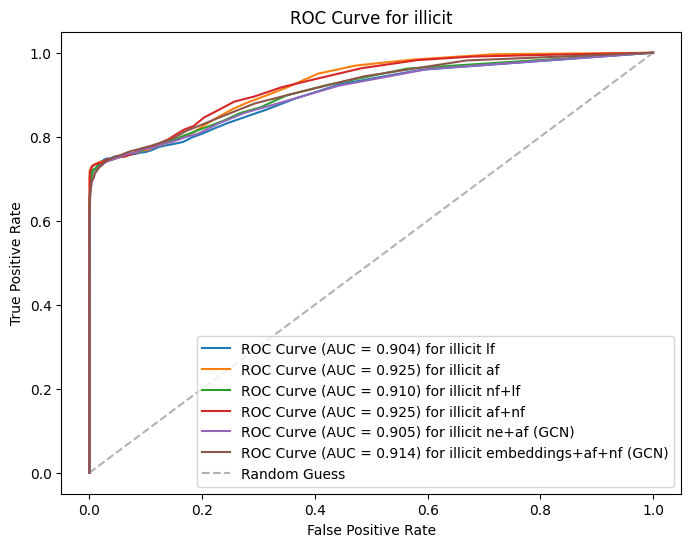

In [34]:
y_test_binary = (y_test == '1').astype(int)

class_index_lf = clf_LF.classes_.tolist().index('1')  
y_prob_lf = clf_LF.predict_proba(X_test_LF)[:, class_index_lf]

class_index_af = clf_AF.classes_.tolist().index('1')  
y_prob_af = clf_AF.predict_proba(X_test_AF)[:, class_index_af]

class_index_lf_nf = clf_LF_NF.classes_.tolist().index('1')  
y_prob_lf_nf = clf_LF_NF.predict_proba(X_test_LF_NF)[:, class_index_lf_nf]

class_index_af_nf = clf_AF_NF.classes_.tolist().index('1')  
y_prob_af_nf = clf_AF_NF.predict_proba(X_test_AF_NF)[:, class_index_af_nf]

class_index_ne_af = clf_ne_af.classes_.tolist().index('1')  
y_prob_ne_af = clf_ne_af.predict_proba(X_test_ne_af)[:, class_index_ne_af]

class_index_ne_af_nf = clf_ne_af_nf.classes_.tolist().index('1')  
y_prob_ne_af_nf = clf_ne_af_nf.predict_proba(X_test_ne_af_nf)[:, class_index_ne_af_nf]

fpr_lf, tpr_lf, thresholds_lf = roc_curve(y_test, y_prob_lf, pos_label='1')
fpr_af, tpr_af, thresholds_af = roc_curve(y_test, y_prob_af, pos_label='1')
fpr_lf_nf, tpr_lf_nf, thresholds_lf_nf = roc_curve(y_test, y_prob_lf_nf, pos_label='1')
fpr_af_nf, tpr_af_nf, thresholds_af_nf = roc_curve(y_test, y_prob_af_nf, pos_label='1')
fpr_ne_af, tpr_ne_af, thresholds_ne_af = roc_curve(y_test, y_prob_ne_af, pos_label='1')
fpr_ne_af_nf, tpr_ne_af_nf, thresholds_ne_af_nf = roc_curve(y_test, y_prob_ne_af_nf, pos_label='1')

roc_auc_lf = roc_auc_score(y_test_binary, y_prob_lf)
print(f"ROC-AUC Score for illicit (Local Features): {roc_auc_lf:.3f}")

roc_auc_af = roc_auc_score(y_test_binary, y_prob_af)
print(f"ROC-AUC Score for illicit (All Features): {roc_auc_af:.3f}")

roc_auc_lf_nf = roc_auc_score(y_test_binary, y_prob_lf_nf)
print(f"ROC-AUC Score for illicit (Local Features + Node Features): {roc_auc_lf_nf:.3f}")

roc_auc_af_nf = roc_auc_score(y_test_binary, y_prob_af_nf)
print(f"ROC-AUC Score for illicit (All Features + Node Features): {roc_auc_af_nf:.3f}")

roc_auc_ne_af = roc_auc_score(y_test_binary, y_prob_ne_af)
print(f"ROC-AUC Score for illicit (Node Embeddings + All features (GCN)): {roc_auc_ne_af:.3f}")

roc_auc_ne_af_nf = roc_auc_score(y_test_binary, y_prob_ne_af_nf)
print(f"ROC-AUC Score for illicit (Embeddings + All Features + Node Features (GCN)): {roc_auc_ne_af_nf:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_lf, tpr_lf, label=f"ROC Curve (AUC = {roc_auc_lf:.3f}) for illicit lf")
plt.plot(fpr_af, tpr_af, label=f"ROC Curve (AUC = {roc_auc_af:.3f}) for illicit af")
plt.plot(fpr_lf_nf, tpr_lf_nf, label=f"ROC Curve (AUC = {roc_auc_lf_nf:.3f}) for illicit nf+lf")
plt.plot(fpr_af_nf, tpr_af_nf, label=f"ROC Curve (AUC = {roc_auc_af_nf:.3f}) for illicit af+nf")
plt.plot(fpr_ne_af, tpr_ne_af, label=f"ROC Curve (AUC = {roc_auc_ne_af:.3f}) for illicit ne+af (GCN)")
plt.plot(fpr_ne_af_nf, tpr_ne_af_nf, label=f"ROC Curve (AUC = {roc_auc_ne_af_nf:.3f}) for illicit embeddings+af+nf (GCN)")
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', alpha=0.6, label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for illicit")
plt.legend(loc="lower right")
plt.show()

In [35]:
#import pandas as pd

#importances = clf.feature_importances_
#features = X.columns  

#feature_importances = pd.DataFrame({
#    'Feature': features,
#    'Importance': importances
#})

#feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
#top_features = feature_importances.head(50)

#print(top_features)


# Data visualization

In [36]:
#import matplotlib.pyplot as plt
#fig, ax = plt.subplots(figsize=(20, 20)) 
#node_sizes = [c * 50 for c in centralities]
#layout = tx_graph.layout_fruchterman_reingold()
#ig.plot(tx_graph, vertex_size=node_sizes, vertex_frame_width=0.5, edge_width=0.1, bbox=(8000, 8000), margin=50, target=ax)
#plt.savefig("large_graph.png", dpi=300)
#plt.savefig("large_graph.pdf", dpi=600)

In [37]:
#import matplotlib.pyplot as plt

#undirected_graph = tx_graph.as_undirected(combine_edges=None)
#ilicit_indices = [v.index for v in undirected_graph.vs if v['type'] == '1']
#ilicit_graph = undirected_graph.induced_subgraph(ilicit_indices)

#fig, ax = plt.subplots(figsize=(20, 20)) 
#ilicit_centralities = ilicit_graph.closeness()
#node_sizes = [c * 50 for c in centralities]
#layout = ilicit_graph.layout_fruchterman_reingold()
#ig.plot(ilicit_graph, vertex_size=node_sizes, vertex_frame_width=0.5, edge_width=0.1, bbox=(8000, 8000), margin=50, target=ax)
#plt.savefig("ilicit_graph.pdf", dpi=300)

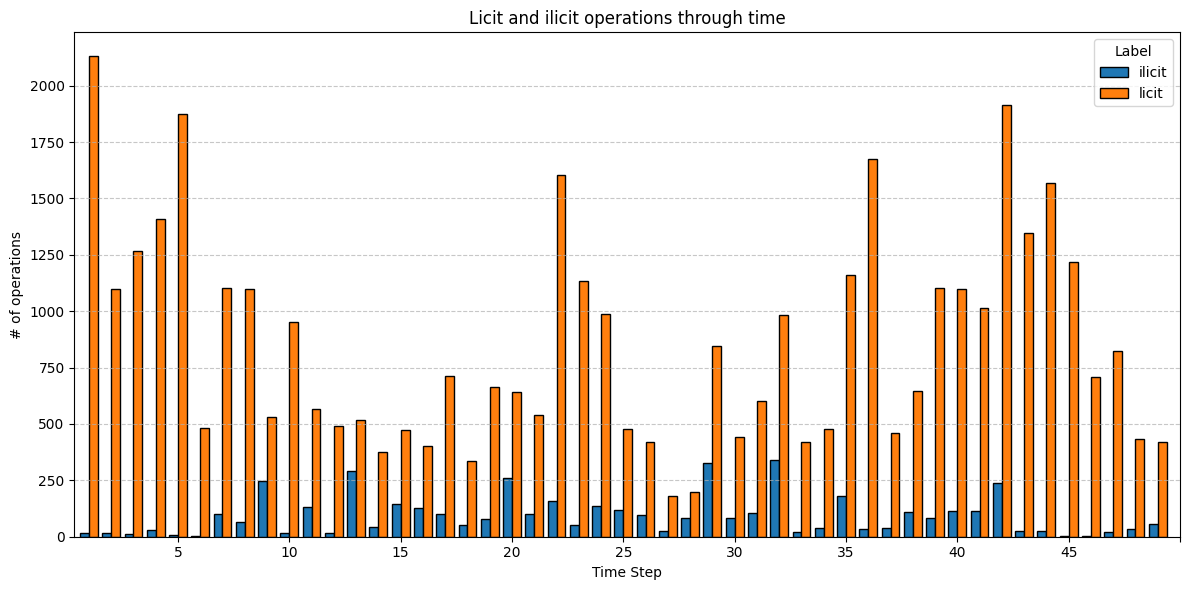

In [38]:
time_steps = X['time_step']

grouped_data = df.groupby(['time_step', 'label']).size().unstack(fill_value=0)
grouped_data.plot(kind='bar', figsize=(12, 6), width=0.8, edgecolor='black')

plt.title('Licit and ilicit operations through time')
plt.xlabel('Time Step')
plt.ylabel('# of operations')
plt.xticks(range(4, 50, 5), rotation=0)
plt.legend(title='Label', labels=['ilicit', 'licit'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

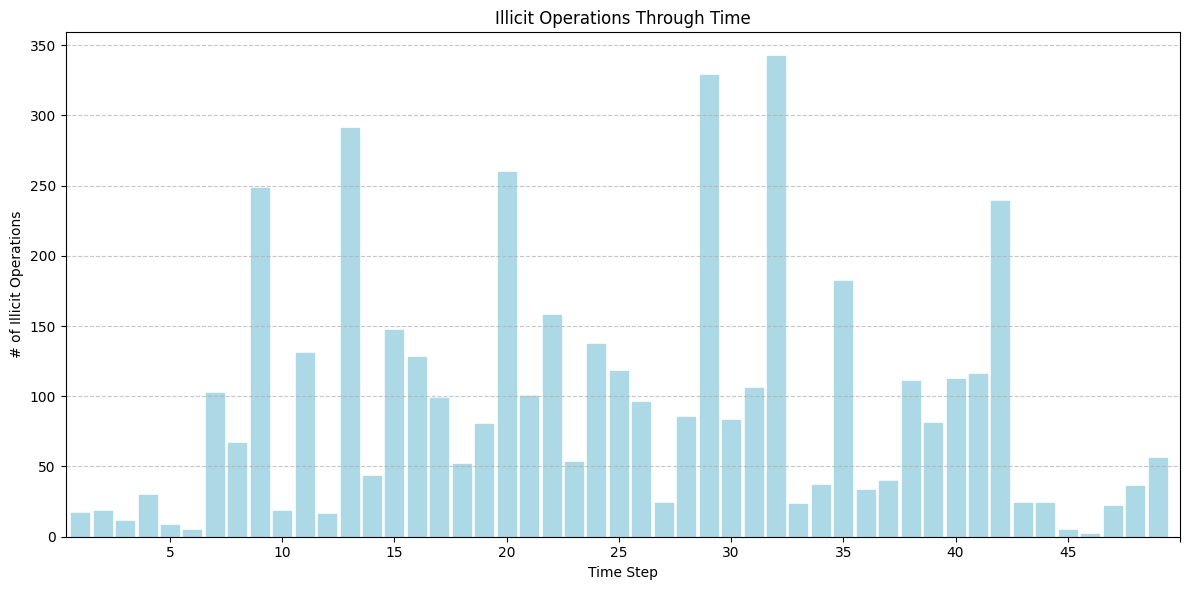

In [39]:
import matplotlib.pyplot as plt


illicit_data = df[df['label'] == '1']

grouped_illicit = illicit_data.groupby('time_step').size()

grouped_illicit.plot(kind='bar', figsize=(12, 6), width=0.8, edgecolor='lightblue', color='lightblue')

plt.title('Illicit Operations Through Time')
plt.xlabel('Time Step')
plt.ylabel('# of Illicit Operations')
plt.xticks(range(4, 50, 5), rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


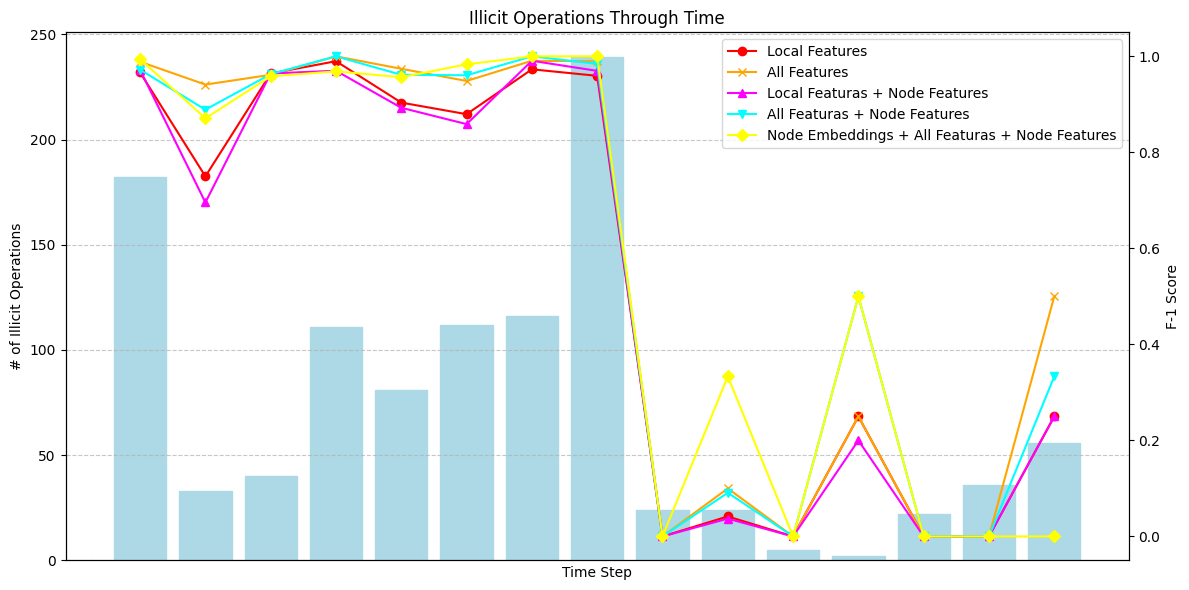

In [40]:

import matplotlib.pyplot as plt

precision_by_time_lf = []
precision_by_time_af = []
precision_by_time_lf_nf = []
precision_by_time_af_nf = []
precision_by_time_ne_af_nf = []

time_steps = sorted(df[df['time_step'] >= 35]['time_step'].unique())

for step in time_steps:
    y_true = y_test[X_test['time_step'] == step]  
    
    y_pred_step_lf = y_pred_LF[X_test['time_step'] == step]
    y_pred_step_af = y_pred_AF[X_test['time_step'] == step]
    y_pred_step_lf_nf = y_pred_LF_NF[X_test['time_step'] == step]
    y_pred_step_af_nf = y_pred_AF_NF[X_test['time_step'] == step]
    y_pred_step_ne_af_nf = y_pred_ne_af_nf[X_test['time_step'] == step]
    

    if len(y_true) > 0:  
        precision_lf = precision_score(y_true, y_pred_step_lf, pos_label='1', zero_division=0)
        precision_af = precision_score(y_true, y_pred_step_af, pos_label='1', zero_division=0)
        precision_lf_nf = precision_score(y_true, y_pred_step_lf_nf, pos_label='1', zero_division=0)
        precision_af_nf = precision_score(y_true, y_pred_step_af_nf, pos_label='1', zero_division=0)
        precision_ne_af_nf = precision_score(y_true, y_pred_step_ne_af_nf, pos_label='1', zero_division=0)
        
        precision_by_time_lf.append(precision_lf)
        precision_by_time_af.append(precision_af)
        precision_by_time_lf_nf.append(precision_lf_nf)
        precision_by_time_af_nf.append(precision_af_nf)
        precision_by_time_ne_af_nf.append(precision_ne_af_nf)
    else:
        precision_by_time_lf.append(0)  
        precision_by_time_af.append(0)
        precision_by_time_lf_nf.append(0)
        precision_by_time_af_nf.append(0)
        precision_by_time_ne_af_nf.append(0)

fig, ax1 = plt.subplots(figsize=(12, 6))

illicit_data = df[(df['label'] == '1') & (df['time_step'] >= 35)]

grouped_illicit = illicit_data.groupby('time_step').size()

plt.title('Illicit Operations Through Time')

ax1.set_xlabel('Time Step')
ax1.set_ylabel('# of Illicit Operations')
ax1.set_xticks(range(len(grouped_illicit)), grouped_illicit.index, rotation=0)
ax1.bar(time_steps, grouped_illicit, width=0.8, edgecolor='lightblue', color='lightblue')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

ax2 = ax1.twinx()

ax2.set_ylabel('F-1 Score')
line_lf, = ax2.plot(time_steps, precision_by_time_lf, color='red', marker='o')
line_af, = ax2.plot(time_steps, precision_by_time_af, color='orange', marker='x', label='All Features')
line_lf_nf, = ax2.plot(time_steps, precision_by_time_lf_nf, color='magenta', marker='^', label='Local Featuras + Node Features')
line_af_nf, = ax2.plot(time_steps, precision_by_time_af_nf, color='cyan', marker='v', label='All Featuras + Node Features')
line_ne_af_nf, = ax2.plot(time_steps, precision_by_time_ne_af_nf, color='yellow', marker='D', label='Node Embeddings + All Featuras + Node Features')

ax2.legend([line_lf, line_af, line_lf_nf, line_af_nf, line_ne_af_nf], ['Local Features', 'All Features', 'Local Featuras + Node Features', 'All Featuras + Node Features', 'Node Embeddings + All Featuras + Node Features'], loc='upper right')

plt.tight_layout()
plt.show()
